In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer #Yeo-Johnson normalization

In [30]:
def remove_high_corr_features(df, threshold=0.95):
    """Remove features with correlation > threshold using upper triangle"""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=drop_cols), drop_cols


In [32]:
def remove_outliers_iqr(df, features=None, multiplier=1.5):
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns

    Q1 = df[features].quantile(0.25)
    Q3 = df[features].quantile(0.75)
    IQR = Q3 - Q1

    is_outlier = ((df[features] < (Q1 - multiplier * IQR)) | 
                  (df[features] > (Q3 + multiplier * IQR))).any(axis=1)

    filtered_df = df[is_outlier == False].copy()
    num_removed = is_outlier.sum()

    return filtered_df, num_removed


In [33]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_scaffold_modified(smiles):
    if not isinstance(smiles, str) or smiles is None:
        return "INVALID"

    mol = Chem.MolFromSmiles(smiles)
    if mol:
        try:
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            if scaffold.GetNumAtoms() == 0:
                return Chem.MolToSmiles(mol)
            return Chem.MolToSmiles(scaffold)
        except:
            return "INVALID"
    return "INVALID"


In [34]:
def scaffold_split_three_way(df, smiles_column="SMILES", val_frac=0.1, test_frac=0.1, seed=42):
    df = df.copy()
    np.random.seed(seed)
    
    df["Scaffold"] = df[smiles_column].apply(get_scaffold_modified)
    scaffold_groups = df.groupby("Scaffold")
    
    scaffolds = list(scaffold_groups.groups.keys())
    np.random.shuffle(scaffolds)

    train_idx, val_idx, test_idx = [], [], []
    total = len(df)
    val_target = int(val_frac * total)
    test_target = int(test_frac * total)
    val_count = test_count = 0

    for scaffold in scaffolds:
        indices = list(scaffold_groups.groups[scaffold])
        if val_count + len(indices) <= val_target:
            val_idx.extend(indices)
            val_count += len(indices)
        elif test_count + len(indices) <= test_target:
            test_idx.extend(indices)
            test_count += len(indices)
        else:
            train_idx.extend(indices)

    df_train = df.loc[train_idx].drop(columns=["Scaffold"]).reset_index(drop=True)
    df_val = df.loc[val_idx].drop(columns=["Scaffold"]).reset_index(drop=True)
    df_test = df.loc[test_idx].drop(columns=["Scaffold"]).reset_index(drop=True)

    return df_train, df_val, df_test


In [37]:
def main():
    # Reproducibility
    np.random.seed(42)
    
    # Load and clean data
    df = pd.read_csv("../data/curated-solubility-dataset.csv")
    
    # Handle MolLogP outliers
    df = df[(df["Solubility"] <= 1) & (df["Solubility"] >= -9)]
    
    # Save SMILES before dropping
    smiles_series = df["SMILES"]

    # Drop non-feature columns
    non_features = ["ID","Name","InChI","InChIKey","SMILES","SD","Ocurrences","Group"]
    df = df.drop(columns=non_features)
    
    # Safety check: Verify numeric features
    assert df.select_dtypes(exclude=np.number).empty, "Non-numeric features present" 
    
    # Split data
    y = df["Solubility"]
    X = df.drop(columns=["Solubility"])
    
    # Remove correlated features
    X, removed = remove_high_corr_features(X, 0.95)
    print(f"Removed high-corr features: {removed}")  #! Transparency

    X_outliers_removed, num_outliers = remove_outliers_iqr(X)
    y = y.loc[X_outliers_removed.index] # keep y aligend
    X = X_outliers_removed
    print(f"Removed {num_outliers} outlier rows based on IQR.")
    
    # Train-validation split - old but kept for reference
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Merge X and y to prepare for scaffold split
    df_xy = X.copy()
    df_xy["Solubility"] = y
    df_xy["SMILES"] = smiles_series.loc[df_xy.index]  # Needed for scaffold

    # Apply scaffold split
    df_train, df_val, df_test = scaffold_split_three_way(df_xy, smiles_column="SMILES", val_frac=0.1, test_frac=0.1)

    # Separate again
    X_train = df_train.drop(columns=["Solubility", "SMILES"])
    y_train = df_train["Solubility"]

    X_val = df_val.drop(columns=["Solubility", "SMILES"])
    y_val = df_val["Solubility"]

    X_test = df_test.drop(columns=["Solubility", "SMILES"])
    y_test = df_test["Solubility"]


    # Fit PowerTransformer on training set ONLY instead of full dataset 
    # avoids leaking validation stats into training
    pt = PowerTransformer(method='yeo-johnson')
    X_train = pd.DataFrame(pt.fit_transform(X_train), columns=X.columns, index=X_train.index)
    X_val = pd.DataFrame(pt.transform(X_val), columns=X.columns, index=X_val.index)
    X_test = pd.DataFrame(pt.transform(X_test), columns=X_test.columns, index=X_test.index)

    print("Applied Yeo-Johnson normalization fitted on training data")
    
    # Optimized XGBoost configuration
    model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_estimators=2000, 
        learning_rate=0.02, 
        max_depth=6,      
        subsample=0.8,       
        colsample_bytree=0.7,
        reg_alpha=0.1,       #! L1 
        reg_lambda=1.0,      #! L2 
        early_stopping_rounds=20,  
        random_state=42
    )
    
    # Training with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=50
    )
    
    # Evaluation on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"\nValidation RMSE: {rmse:.4f}")
    print(f"Validation R²: {r2:.4f}")
    
    #plots
    plt.figure(figsize=(10,6))
    plot_importance(model, max_num_features=15)
    plt.title("XGBoost Feature Importance")
    plt.show()

Removed high-corr features: ['HeavyAtomCount', 'NumValenceElectrons', 'LabuteASA']
Removed 3618 outlier rows based on IQR.


[14:45:31] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:45:31] Explicit valence for atom # 5 N, 4, is greater than permitted


Applied Yeo-Johnson normalization fitted on training data
[0]	validation_0-rmse:2.06269
[50]	validation_0-rmse:1.26491
[100]	validation_0-rmse:1.06863
[150]	validation_0-rmse:1.01205
[200]	validation_0-rmse:0.99251
[250]	validation_0-rmse:0.98381
[300]	validation_0-rmse:0.97874
[330]	validation_0-rmse:0.97731

Validation RMSE: 1.1011
Validation R²: 0.7138


<Figure size 1000x600 with 0 Axes>

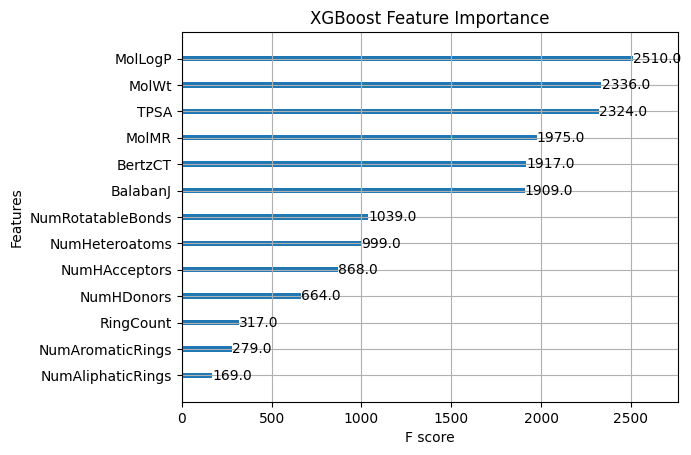

In [38]:
if __name__ == "__main__":
    main()